# Multiple layers in Convolutional neural network

- CNN can have multiple input and output feature matrices
- Filters (or kernels) connects inputs to outputs by convolving the inputs to produce outputs
- Each kernel has its own set of weights (e.g., 3×3)
- The total number of kernels = (number of input channels) × (number of output channels)
- The number of kernels contributing to a particular output is always equal to the number of inputs

Each output is formed by multiplying each input with corresponding kernel and adding it together:
$$z_i=\sum_{j=1}^{m} x_j w_{i, j} + b_i$$

- _i_ - output number (1, n)
- _j_ - input number (1, m)

Therefore, if we have 2 inputs and produce 2 outputs, then we calculate outputs as follows:
$$z_1=x_1*w_{1,1}+x_2*w_{1,2} + b_1$$
$$z_2=x_1*w_{2,1}+x_2*w_{2,2} + b_2$$

## Introduction

### Random image 5x5

In [1]:
import torch

image = torch.zeros(1, 1, 5, 5)
image[0, 0, :, 2] = 1
image

tensor([[[[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.]]]])

### Parameters

In [2]:
Gx = torch.tensor([
    [1.0, 0, -1.0],
    [2.0, 0, -2.0],
    [1.0, 0.0, -1.0]
])
Gy = torch.tensor([
    [1.0, 2.0, 1.0],
    [0.0, 0.0, 0.0],
    [-1.0, -2.0, -1.0]
])
Gz = torch.ones(3, 3)

bias = torch.tensor([0.0, 0.0, 0.0])

### Convolution (1 input, 3 outputs, 3 kernels)

In [3]:
import torch.nn as nn

cnn_outputs3_filters3 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)

cnn_outputs3_filters3.state_dict()['weight'][0][0] = Gx
cnn_outputs3_filters3.state_dict()['weight'][1][0] = Gy
cnn_outputs3_filters3.state_dict()['weight'][2][0] = Gz
cnn_outputs3_filters3.state_dict()['bias'][:] = bias

print(cnn_outputs3_filters3.state_dict())

OrderedDict({'weight': tensor([[[[ 1.,  0., -1.],
          [ 2.,  0., -2.],
          [ 1.,  0., -1.]]],


        [[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]],


        [[[ 1.,  1.,  1.],
          [ 1.,  1.,  1.],
          [ 1.,  1.,  1.]]]]), 'bias': tensor([0., 0., 0.])})


In [4]:
outputs = cnn_outputs3_filters3(image)
print(outputs)
print(outputs.shape)

tensor([[[[-4.,  0.,  4.],
          [-4.,  0.,  4.],
          [-4.,  0.,  4.]],

         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],

         [[ 3.,  3.,  3.],
          [ 3.,  3.,  3.],
          [ 3.,  3.,  3.]]]], grad_fn=<ConvolutionBackward0>)
torch.Size([1, 3, 3, 3])


### Outputs visualization

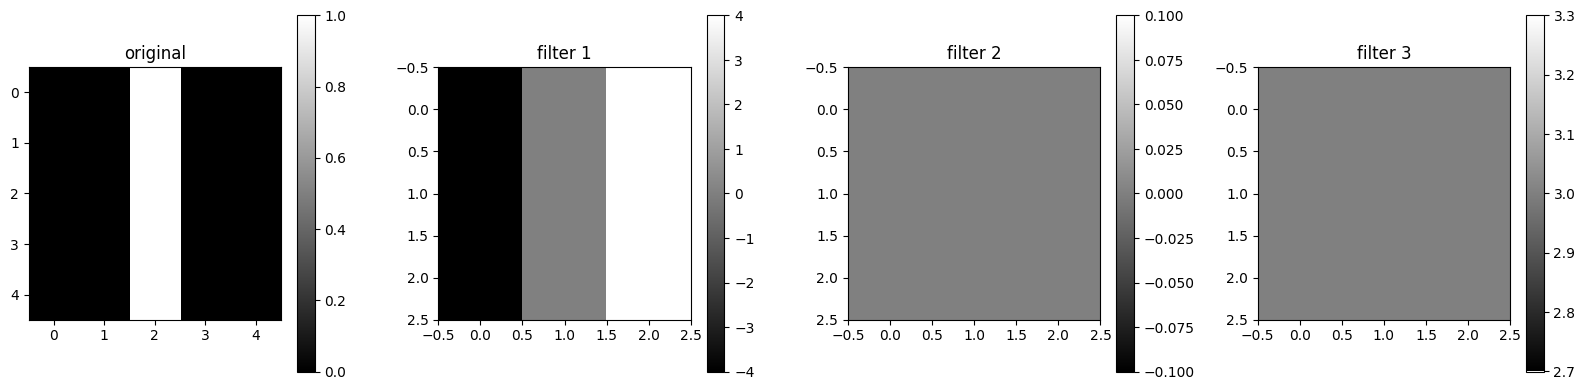

In [5]:
from matplotlib import pyplot as plt

images = [image, *outputs[0]]
labels = ["original"] + [f"filter {i + 1}" for i in range(outputs.shape[1])]

n = len(images)
fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

for ax, img_tensor, label in zip(axes, images, labels):
    img_np = img_tensor.squeeze().detach().numpy()

    ax.set_title(label)
    im = ax.imshow(img_np, cmap="gray")
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## Task 1: Convolution of the Jupiter image (3 inputs (RGB), 3 outputs, 3 filters per channel)

In [6]:
from PIL import Image
import torchvision.transforms as transforms

# © NASA, ESA, and J. Nichols (University of Leicester)
image_path = "../resources/Jupiter NASA (1920x1913).jpg"
image = Image.open(image_path).convert("RGB")

image_tensor = transforms.ToTensor()(image)
image_tensor = image_tensor.unsqueeze(0)  # add batch dimension

print(image_tensor.shape)

torch.Size([1, 3, 1913, 1920])


**Weight is set to calculate color dominance masks**

In [7]:
import torch.nn.functional as F

cnn_rgb = nn.Conv2d(
    in_channels=3,
    out_channels=3,
    kernel_size=3,
    padding=1,
    bias=False
)

with torch.no_grad():
    # Output 0: red-dominant
    cnn_rgb.weight[0][0] = torch.tensor([[1.0]])  # red
    cnn_rgb.weight[0][1] = torch.tensor([[-0.6]])  # subtract green
    cnn_rgb.weight[0][2] = torch.tensor([[-0.6]])  # subtract blue

    # Output 1: green-dominant
    cnn_rgb.weight[1][0] = torch.tensor([[-0.6]])
    cnn_rgb.weight[1][1] = torch.tensor([[1.0]])
    cnn_rgb.weight[1][2] = torch.tensor([[-0.6]])

    # Output 2: blue-dominant
    cnn_rgb.weight[2][0] = torch.tensor([[-0.6]])
    cnn_rgb.weight[2][1] = torch.tensor([[-0.6]])
    cnn_rgb.weight[2][2] = torch.tensor([[1.0]])

output_rgb = cnn_rgb(image_tensor)
output_rgb = F.relu(output_rgb)
print(output_rgb.shape)

torch.Size([1, 3, 1913, 1920])


### Normalization to the float range (0-1) per channel

In [8]:
min_output_values = output_rgb.amin(dim=(2, 3), keepdim=True)  # only spatial dimensions
max_output_values = output_rgb.amax(dim=(2, 3), keepdim=True)

d = max_output_values - min_output_values
d[d == 0] = 1.0  # avoid division by zero for constant channels

output_rgb_normalized = (output_rgb - min_output_values) / d
print(output_rgb_normalized.shape)

torch.Size([1, 3, 1913, 1920])


### Visualization

In [9]:
def channel_to_rgb(channel, color_index):
    """Convert a single-channel tensor to full RGB"""
    H, W = channel.shape

    rgb = torch.zeros(3, H, W)  # empty 3-channel tensor
    rgb[color_index] = channel

    return rgb.permute(1, 2, 0)  # converts CHW (channel, height, width) to HWC

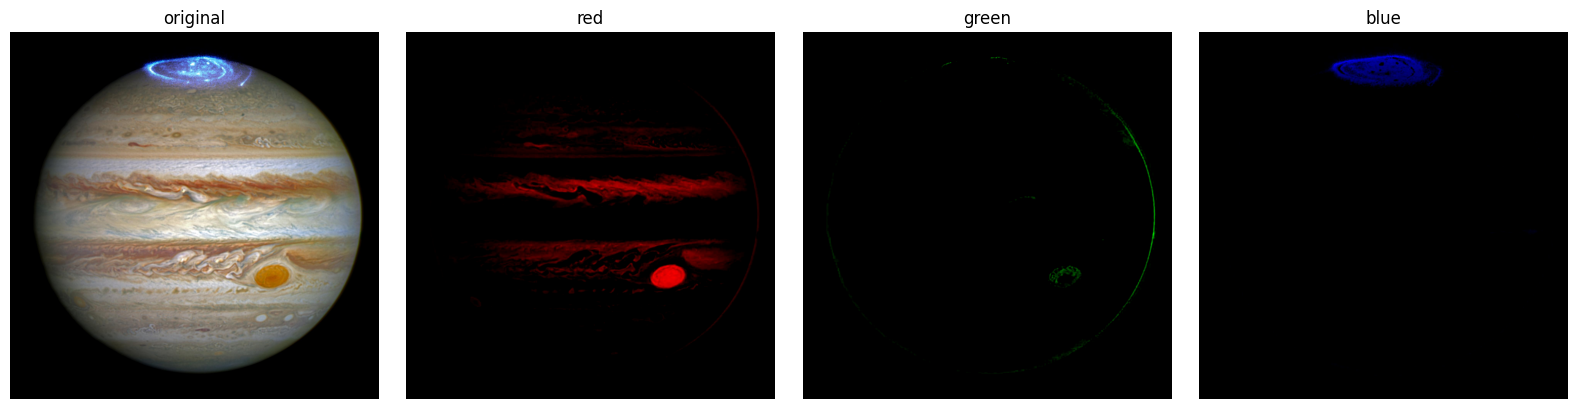

In [10]:
from matplotlib import pyplot as plt

original = image_tensor.squeeze().permute(1, 2, 0)  # converts CHW (channel, height, width) to HWC

# convert single channels to the full RGB tensor each
orgbn = output_rgb_normalized
red_rgb = channel_to_rgb(orgbn[0, 0, :, :], 0)
green_rgb = channel_to_rgb(orgbn[0, 1, :, :], 1)
blue_rgb = channel_to_rgb(orgbn[0, 2, :, :], 2)

images = [original, red_rgb, green_rgb, blue_rgb]
labels = ["original", "red", "green", "blue"]

n = len(images)

fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
for ax, img, label in zip(axes, images, labels):
    ax.imshow(img.squeeze().detach().numpy())
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()